In [1]:
# load packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm
import requests

from sklearn.datasets import load_boston

%matplotlib inline
sns.set()

In [2]:
df = load_boston()
boston = pd.DataFrame(df.data, columns=df.feature_names)
boston['Price'] = df.target
X = boston.iloc[:, :-1]
y = boston.iloc[:, -1]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
linreg = LinearRegression().fit(X_train, y_train)
print(f'In-sample MSE: {mean_squared_error(y_train, linreg.predict(X_train))}')
print(f'Out-sample MSE: {mean_squared_error(y_test, linreg.predict(X_test))}')

In-sample MSE: 19.34825475625585
Out-sample MSE: 30.119048511444202


In [4]:
poly = PolynomialFeatures(degree=2, interaction_only=False)
pipeline = make_pipeline(poly, LinearRegression()).fit(X_train, y_train)
print(f'In-sample MSE: {mean_squared_error(y_train, pipeline.predict(X_train))}')
print(f'Out-sample MSE: {mean_squared_error(y_test, pipeline.predict(X_test))}')


In-sample MSE: 5.7263599318921194
Out-sample MSE: 14.062763575306372


As seen above, the difference between in-sample & out-sample results is enormous, therefore it's a sign of
<b>overfitting</b>!


### Dealing with a hardcore dataset - Madelon


In [5]:
X_train = np.loadtxt('datasets/madelon_train.data')
y_train = np.loadtxt('datasets/madelon_train.labels')

# do not touch this one!
X_validation = np.loadtxt('datasets/madelon_valid.data')
y_validation = np.loadtxt('datasets/madelon_valid.labels')

In [6]:
# since we can't use pandas.describe(), we can use scipy's same function
from scipy.stats import describe

describe(X_train)[:2]


(2000,
 (array([462., 381., 370., 453., 371., 459., 334., 471., 430., 455., 354.,
         389., 347., 352., 444., 410., 433., 377., 408., 441., 426., 412.,
         456., 438., 343., 416., 421., 441., 438., 417., 451., 382., 369.,
         363., 384., 342., 441., 396., 464., 471., 463., 362., 392., 438.,
         406., 392., 371., 373., 367., 382., 381., 382., 399., 465., 401.,
         409., 288., 377., 378., 408., 400., 462., 377., 458., 214., 385.,
         373., 395., 462., 452., 362., 427., 402., 354., 456., 371., 446.,
         396., 379., 424., 415., 385., 396., 430., 372., 391., 458., 406.,
         454., 377., 474., 395., 399., 438., 452., 384., 468., 406., 412.,
         355., 448., 448., 460., 428., 361.,   0., 349., 370., 391., 442.,
         392., 356., 450., 385., 353., 413., 418., 441., 389., 414., 469.,
         380., 437., 355., 406., 389., 440., 387., 435., 347., 401., 420.,
         402., 461., 403., 382., 369., 425., 461., 430., 427., 376., 443.,
         452., 421

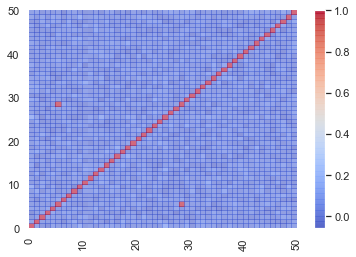

In [7]:
import matplotlib as mpl

# visualize all the nightmare above
def visualize_correlation_matrix(data, hurdle=0.0):
    R = np.corrcoef(data, rowvar=0)
    R[np.where(np.abs(R) < hurdle)] = 0.0
    heatmap = plt.pcolor(R, cmap=mpl.cm.coolwarm, alpha=0.6)
    heatmap.axes.set_frame_on(False)
    plt.xticks(rotation=90)
    plt.tick_params(axis='both', which='both')
    plt.colorbar()
    plt.show()

visualize_correlation_matrix(X_train[:, 100:150])

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc

log_reg = LogisticRegression(max_iter=1e5).fit(X_train, y_train)
print(log_reg.score(X_train, y_train))

print(f'Training area under the curve: {round(roc_auc_score(y_train, log_reg.predict_proba(X_train)[:, 1]), 3)}')
print(f'Validation area under the curve: {round(roc_auc_score(y_validation, log_reg.predict_proba(X_validation)[:, 1]), 3)}')


0.744
Training area under the curve: 0.824
Validation area under the curve: 0.601


<h1>Univariate Feature Selection</h1>

<h3>SelectPercentile & f_classif</h3>
SelectPercentile is a classification selection of the best parameters (number specified by us) using
<b>percentile</b> as a threshold.

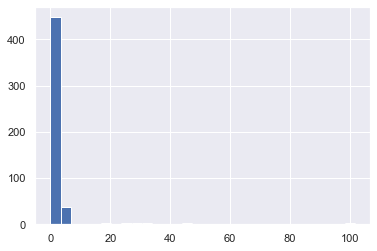

In [9]:
#
from sklearn.feature_selection import SelectPercentile
selector = SelectPercentile(percentile=50).fit(X_train, y_train)
# variable_filter = selector.get_support()

plt.hist(selector.scores_, bins=30, histtype='bar')
plt.show()

In [10]:
from sklearn.preprocessing import PolynomialFeatures

# now select the most important features
variable_filter = selector.scores_ > 10
print(f'Number of filtered variables: {np.sum(variable_filter)}')

interactions = PolynomialFeatures(degree=2, interaction_only=True)
Xs = interactions.fit_transform(X_train[:, variable_filter])
print(f'Number of variables and interactions: {Xs.shape}')

Number of filtered variables: 13
Number of variables and interactions: (2000, 92)


### As we can see, the number of features decreased from 92 to 13

Now, let's try and catch any relevant non-linear relationships

In [11]:
log_reg.fit(Xs, y_train)
Xvs = interactions.fit_transform(X_validation[:, variable_filter])
print(f'Validation under the curve: {roc_auc_score(y_validation, log_reg.predict_proba(Xvs)[:, 1])}')

Validation under the curve: 0.8115777777777778


## Recursive Feature Selection
The only problem with univariate selection is that it will decide the best features by
considering each feature separately from the others, not verifying how they work together
in unison. Consequently, redundant variables are not infrequently picked (due to
collinearity).

A multivariate approach, such as recursive elimination, can avoid this problem; however,
it is more computationally expensive.


In [17]:
# boston dataset
X_bost = boston.iloc[:, :-1]
y_bost = boston.iloc[:, -1]

from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

X_train, X_test, y_train, y_test = train_test_split(X_bost, y_bost, test_size=0.3, random_state=32)

poly = PolynomialFeatures(degree=2)

lm = LinearRegression()
cv_iter = KFold(n_splits=10, shuffle=True, random_state=101)
recursive_selector = RFECV(estimator=lm, step=1,
                           cv=cv_iter, scoring='neg_mean_squared_error').fit(poly.fit_transform(X_train), y_train)
print(f'Initial # of features: {poly.fit_transform(X_train).shape[1]}')
print(f'Extracted # of features: {recursive_selector.n_features_}')


Initial # of features: 105
Extracted # of features: 70


In [18]:
essential_X_train = recursive_selector.transform(poly.fit_transform(X_train))
essential_X_test = recursive_selector.transform(poly.fit_transform(X_test))
lm.fit(essential_X_train, y_train)
print('cases = %i features = %i' % essential_X_test.shape)
print(f'In-sample mean squared error: {mean_squared_error(y_train, lm.predict(essential_X_train))}')
print(f'Out-sample mean squared error: {mean_squared_error(y_test, lm.predict(essential_X_test))}')

cases = 152 features = 70
In-sample mean squared error: 6.580745978516398
Out-sample mean squared error: 10.868680073124048


In [23]:
# cross validation
# from sklearn.model_selection import StratifiedKFold
edges = np.histogram(y, bins=5)[1]
binning = np.digitize(y, edges)
stratified_cv = KFold(10, shuffle=True, random_state=101)
essential_X = recursive_selector.transform(poly.fit_transform(X))
cv_score = cross_val_score(lm, essential_X, y, cv=stratified_cv, scoring='neg_mean_squared_error')
print(f'CV score - MEAN: {np.mean(np.abs(cv_score))}, STD: {np.std(cv_score)}')


CV score - MEAN: 13.050613285527698, STD: 4.704360903947743
